# Visualização de Dados de Machine Learning
    
Este notebook demonstra a visualização inicial e a análise dos dados para um projeto de machine learning. O objetivo é entender melhor a estrutura dos dados, incluindo as características das amostras, a distribuição das classes e preparar o terreno para uma divisão eficiente em conjuntos de treino e teste.

## Importação das Bibliotecas

Começamos importando as bibliotecas necessárias para manipulação e visualização dos dados.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
import os
import seaborn as sns
from sklearn.decomposition import PCA
from datetime import datetime
from skimage.transform import rotate, warp, AffineTransform
from skimage.util import random_noise
from skimage.exposure import adjust_gamma
import matplotlib.pyplot as plt
import random


## Carregamento dos Dados

Carregamos os dados, que consistem em características (X) e rótulos (Y), a partir de arquivos `.npy`.

In [15]:
X_original = np.load('archive/X.npy')
Y_original = np.load('archive/Y.npy')

## Verificação das Dimensões dos Dados

É crucial entender as dimensões dos nossos conjuntos de dados para planejar as próximas etapas de análise e modelagem.

In [16]:
print(f'Dimensões de X: {X_original.shape}')
print(f'Dimensões de Y: {Y_original.shape}')

print(f'Número de imagens: {X_original.shape[0]}')

Dimensões de X: (2062, 64, 64)
Dimensões de Y: (2062, 10)
Número de imagens: 2062


## Visualização de Amostras

Visualizamos algumas amostras das imagens para ter uma ideia da aparência dos dados e das classes que estamos tentando prever.

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Labels:  [0 0 0 ... 9 9 9]


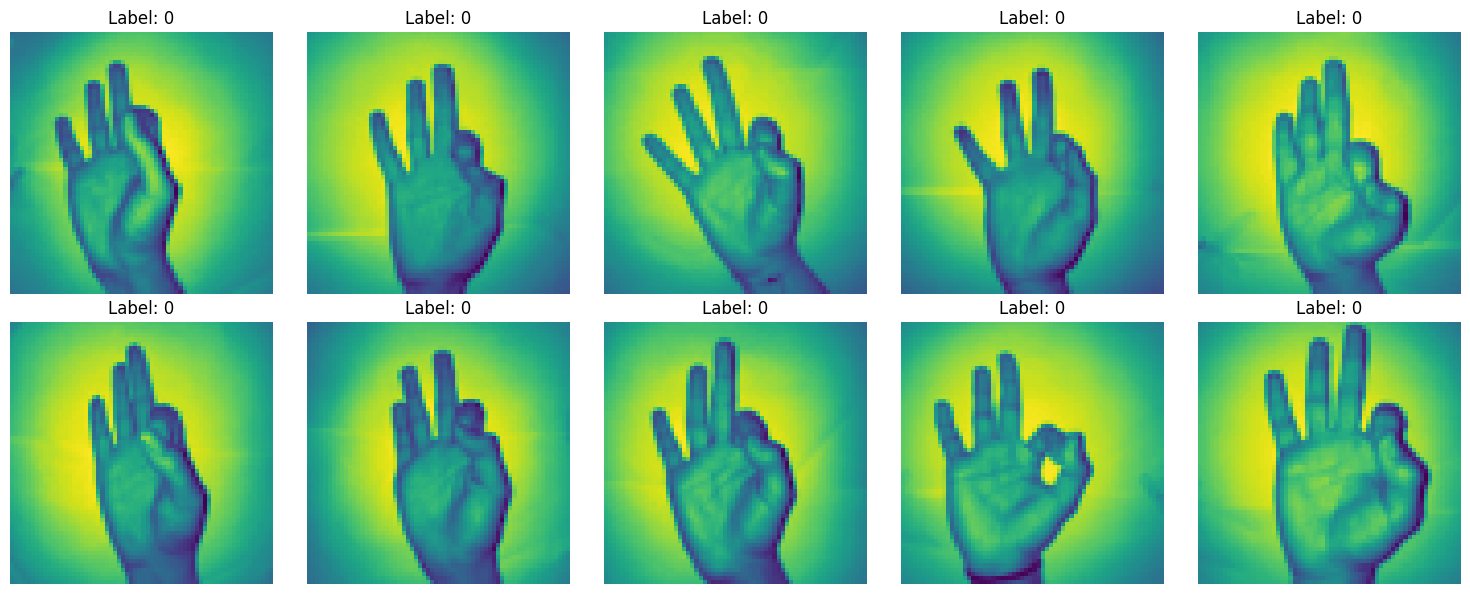

In [17]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))

#print the labels
print(Y_original[:10])

print('Labels: ', np.argmax(Y_original[:2000], axis=1))

for i in range(10):
    ax = axs[i // 5, i % 5]
    ax.imshow(X_original[i])
    ax.title.set_text('Label: ' + str(np.argmax(Y_original[i])))
    ax.axis('off')
plt.tight_layout()
plt.show()

A partir da amostra dos dados, com especial enfase na distribuição das classes e das labels, verificámos que as o dataset não está organizado, i.e, as imagens não estão ordenadas pelo digito que representam mas sim aleatoriamente. Para resolver este problema, para melhorar a visualização e a análise dos dados, vamos organizar o dataset de forma a que as imagens estejam ordenadas pelo digito que representam.

## Organização dos Dados 

In [18]:
def save_dataset_with_timestamp(X, Y, prefix='archive/X', suffix='archive/Y'):
    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    np.save(f'{prefix}_{timestamp}.npy', X)
    np.save(f'{suffix}_{timestamp}.npy', Y)

X = np.copy(X_original)
Y = np.copy(Y_original)

# Mapping classes to the correct digits
# class 0 = digit 9, class 1 = digit 0, class 2 = digit 7, class 3 = digit 6, class 4 = digit 1, class 5 = digit 8, class 6 = digit 4, class 7 = digit 3, class 8 = digit 2, class 9 = digit 5

class_to_digit = {0: 9, 1: 0, 2: 7, 3: 6, 4: 1, 5: 8, 6: 4, 7: 3, 8: 2, 9: 5}

# Convert Y from one-hot encoding to class indices
labels_indices = np.argmax(Y, axis=1)

# Correct the indices based on the mapping
correted_labels = np.array([class_to_digit[label] for label in labels_indices])

# Convert back to one-hot encoding
correted_Y = np.eye(10)[correted_labels]

print('Labels corrigidos: ', correted_labels[:2000])

# Sort the dataset by the digit each sample represents
sorted_indices = np.argsort(correted_labels)

print('Labels ordenados: ', correted_labels[sorted_indices])

# ordenar os labels
correted_Y = correted_Y[sorted_indices]
correted_X = X[sorted_indices]

# salvar os dados
save_dataset_with_timestamp(correted_X, correted_Y)


Labels corrigidos:  [9 9 9 ... 5 5 5]
Labels ordenados:  [0 0 0 ... 9 9 9]


## Dataset Augmentation

Dataset augmentation is a common technique used to artificially increase the size of a dataset by applying various transformations to the existing data samples. This can help improve the generalization and robustness of machine learning models, especially in scenarios where the original dataset is limited in size.

Novo tamanho de X: (26806, 64, 64)
Novo tamanho de Y: (26806, 10)
Número de imagens: 26806


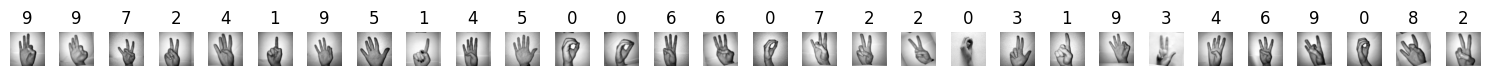

In [44]:
def rotate_images(images, num_copies=3, angle_range=(-30, 30)):
    rotated_images = []
    for image in images:
        for _ in range(num_copies):
            angle = random.uniform(*angle_range)
            rotated_images.append(rotate(image, angle, mode='wrap'))
    return rotated_images

def add_gaussian_noise(images, copies=3):
    noised_images = []
    for image in images:
        for _ in range(copies):
            noised_images.append(random_noise(image, mode='gaussian', var=0.01**2))
    return noised_images

def apply_gamma_contrast(images, copies=3):
    contrasted_images = []
    for image in images:
        for _ in range(copies):
            gamma = random.uniform(0.8, 1.2)  # Gamma values around 1 (0.8 to 1.2)
            contrasted_images.append(adjust_gamma(image, gamma))
    return contrasted_images

def translate_images(images, copies=3):
    translated_images = []
    for image in images:
        for _ in range(copies):
            translation = (random.randint(-5, 5), random.randint(-5, 5))
            transform = AffineTransform(translation=translation)
            translated_images.append(warp(image, transform, mode='wrap', preserve_range=True).astype(image.dtype))
    return translated_images

# Aplicar todas as técnicas por classe e combinar de volta
X_augmented_by_class = []
Y_augmented_by_class = []

for digit in range(10):
    # Extrair imagens de uma classe
    class_indices = np.where(labels_indices == digit)[0]
    X_class = correted_X[class_indices]
    Y_class = correted_Y[class_indices]

    # Aplicar augmentação
    rotated = rotate_images(X_class)
    noised = add_gaussian_noise(X_class)
    contrasted = apply_gamma_contrast(X_class)
    translated = translate_images(X_class)

    # Concatenar as imagens modificadas com as originais da classe
    X_class_augmented = np.concatenate((X_class, rotated, noised, contrasted, translated))
    Y_class_augmented = np.concatenate((Y_class, *(Y_class for _ in range(4 * 3))))

    # Adicionar ao dataset por classe
    X_augmented_by_class.append(X_class_augmented)
    Y_augmented_by_class.append(Y_class_augmented)

# Combinar todas as classes de volta em um único dataset
X_augmented = np.concatenate(X_augmented_by_class)
Y_augmented = np.concatenate(Y_augmented_by_class)

# Salvar os novos datasets em arquivos .npy
np.save('archive/Augmentation/X_augmented.npy', X_augmented)
np.save('archive/Augmentation/Y_augmented.npy', Y_augmented)

# Verificar as dimensões dos novos datasets
print(f'Novo tamanho de X: {X_augmented.shape}')
print(f'Novo tamanho de Y: {Y_augmented.shape}')
print(f'Número de imagens: {X_augmented.shape[0]}')

# Plotar algumas imagens do novo dataset
def plot_images(images, labels, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i, ax in enumerate(axes):
        # Selecionar uma amostra aleatória
        random_index = np.random.choice(range(images.shape[0]))
        ax.imshow(images[random_index], cmap='gray')
        ax.set_title(f'{np.argmax(labels[random_index])}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Plotar algumas imagens do dataset aumentado e os seus respetivos labels
plot_images(X_augmented, Y_augmented, num_images=30)

## Sample Distribution Analysis

To understand the balance between different classes in our dataset, it's useful to visualize the distribution of samples across classes. This helps in identifying if there's a class imbalance that might affect model training.

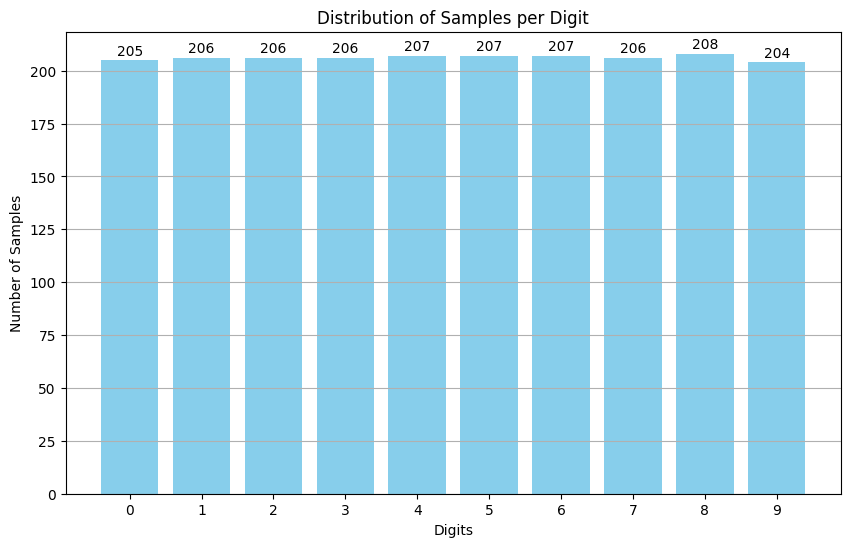

ValueError: 'lightred' is not a valid color value.

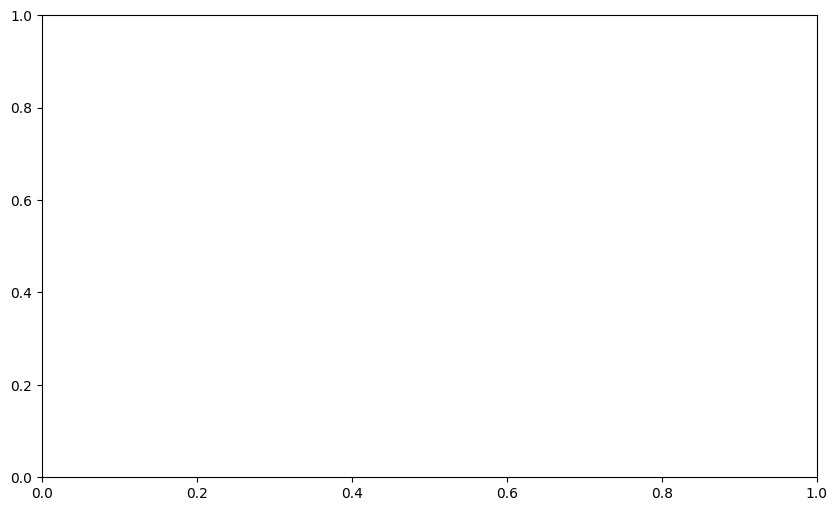

In [45]:
# Count the number of samples per digit
samples_per_digit = np.bincount(correted_labels[sorted_indices])

# Unique classes (assuming classes are sequential and start from 0)
unique_classes = np.arange(len(samples_per_digit))

# count the numver of samples per digits of augmented dataset
labels_indices_augmented = np.argmax(Y_augmented, axis=1)

samples_per_digit_augmented = np.bincount(labels_indices_augmented)

unique_classes_augmented = np.arange(len(samples_per_digit_augmented))


# Create a histogram to visualize the distribution of samples per class
plt.figure(figsize=(10, 6))
plt.bar(unique_classes, samples_per_digit, color='skyblue')
for i in range(len(samples_per_digit)):
    plt.text(i, samples_per_digit[i] + 1, str(samples_per_digit[i]), ha='center', va='bottom')
plt.xlabel('Digits')
plt.ylabel('Number of Samples')
plt.title('Distribution of Samples per Digit')
plt.xticks(unique_classes)
plt.grid(axis='y')

plt.show()

plt.figure(figsize=(10, 6))
plt.bar(unique_classes_augmented, samples_per_digit_augmented, color='lightcoral')
for i in range(len(samples_per_digit_augmented)):
    plt.text(i, samples_per_digit_augmented[i] + 1, str(samples_per_digit_augmented[i]), ha='center', va='bottom')
plt.xlabel('Digits')
plt.ylabel('Number of Samples')
plt.title('Distribution of Samples per Digit Augmented')
plt.xticks(unique_classes_augmented)
plt.grid(axis='y')


## Mean Images Analysis

The Mean Images Analysis is a critical step in exploring the characteristics of our dataset at a glance. By averaging the pixel intensities of all images corresponding to each digit, we obtain a visual 'template' that highlights the most defining features of each class.


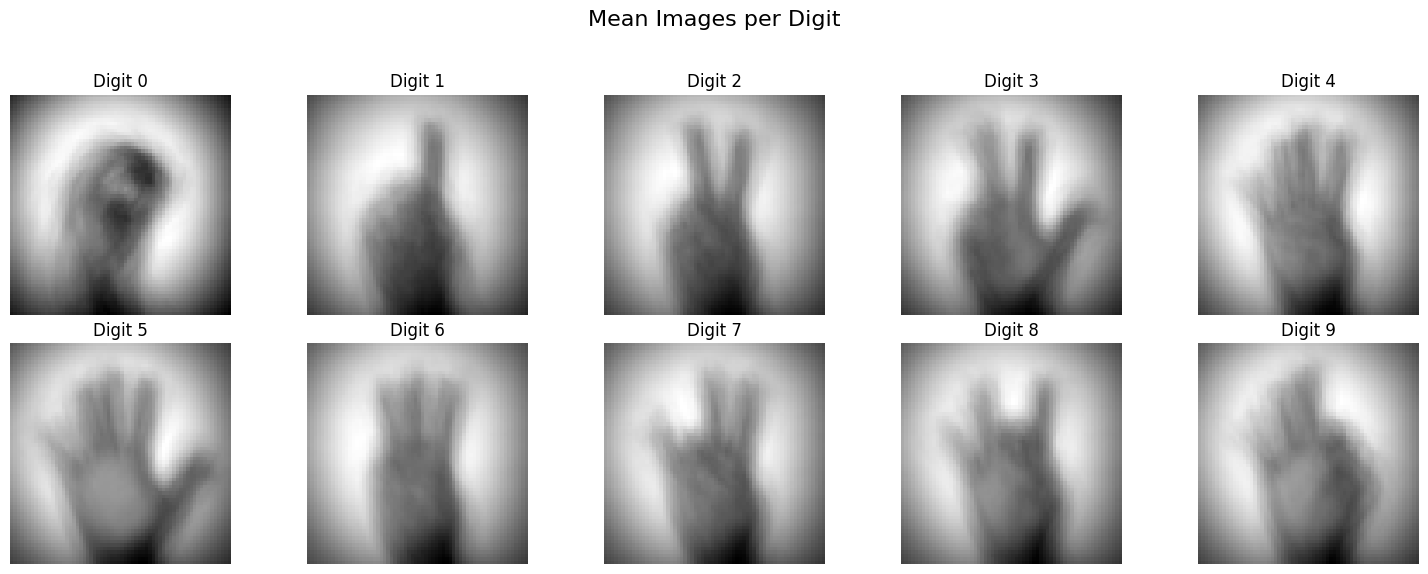

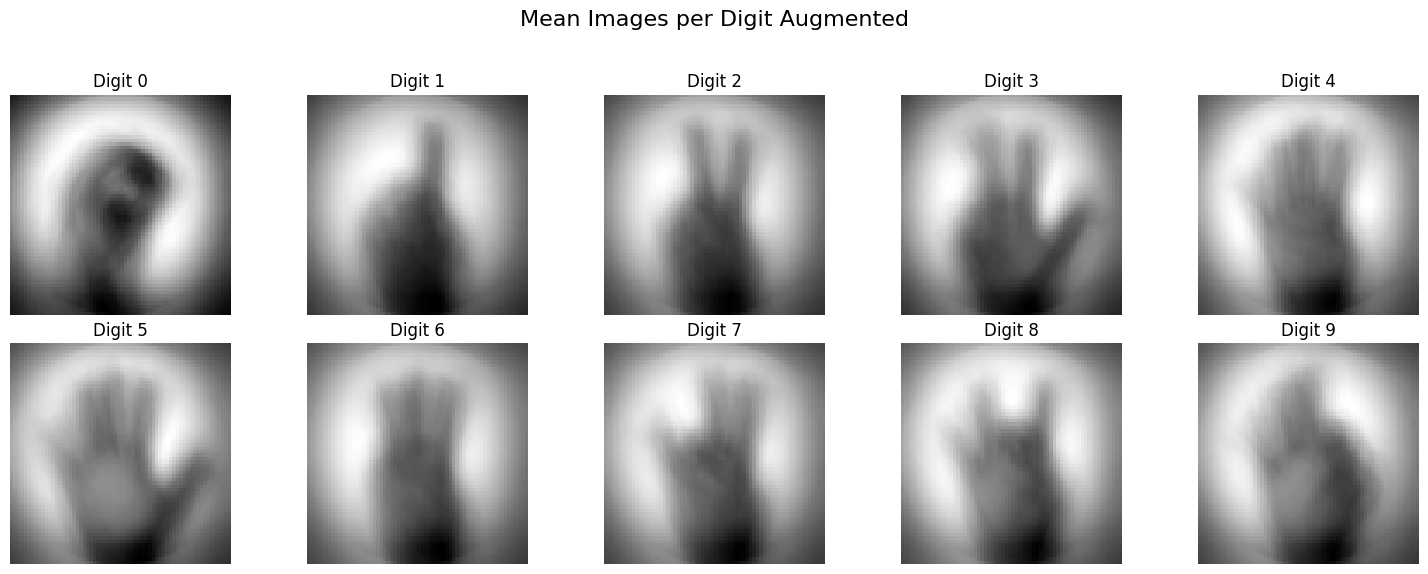

In [38]:
# Calcular a imagem média para cada dígito corrigido
mean_images_corrected = []
for digit in range(10):
    digit_images = correted_X[correted_labels[sorted_indices] == digit]
    mean_image = np.mean(digit_images, axis=0)
    mean_images_corrected.append(mean_image)

# Visualizar as imagens médias corrigidas para cada dígito
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Mean Images per Digit', fontsize=16)
for i, mean_image in enumerate(mean_images_corrected):
    ax = axs[i // 5, i % 5]
    ax.imshow(mean_image, cmap='gray')
    ax.title.set_text(f'Digit {i}')
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

mean_images_augmented = []
for digit in range(10):
    digit_images = X_augmented[labels_indices_augmented == digit]
    mean_image = np.mean(digit_images, axis=0)
    mean_images_augmented.append(mean_image)
    
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Mean Images per Digit Augmented', fontsize=16)
for i, mean_image in enumerate(mean_images_augmented):
    ax = axs[i // 5, i % 5]
    ax.imshow(mean_image, cmap='gray')
    ax.title.set_text(f'Digit {i}')
    ax.axis('off')
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

These mean images serve several important purposes in the context of machine learning:
- They allow us to visually assess the homogeneity within each class of digits. A clear and distinct mean image suggests that the members of the class share common traits.
- They can reveal if certain digits have more variation than others, which might affect the difficulty level for a model to learn and differentiate them.
- They help in identifying if the dataset contains biases or anomalies that could lead to overfitting or poor generalization of a trained model.

The results of this analysis will influence preprocessing decisions and can guide us in choosing and tuning our machine learning models, ensuring that we prioritize features that are most indicative of each class.

## Pixel Value Distribution Analysis

In machine learning models for image recognition, understanding the distribution of pixel values can be crucial. The pixel intensity distribution for each digit can give us insights into the variability of the data and help determine if certain preprocessing steps like normalization or standardization are necessary.


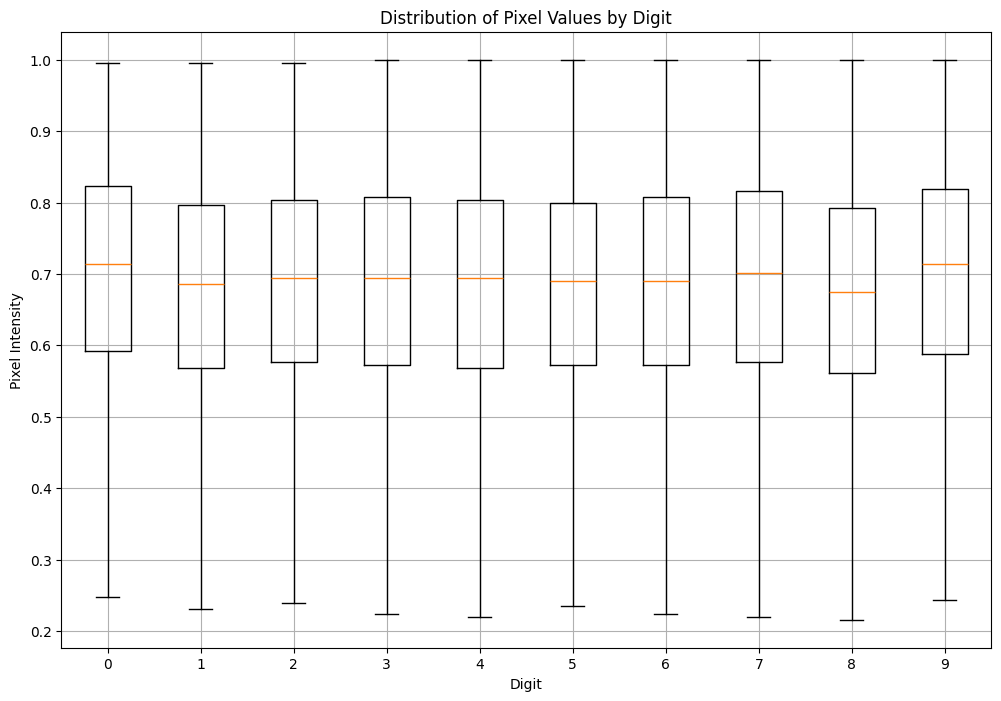

In [22]:
# Preparar os dados para o box plot
# Nota: Ajuste 'correted_X' para 'X_corrected_sorted' e 'correted_labels' para 'corrected_labels'
pixel_values_per_digit = [correted_X[correted_labels == digit].reshape(-1, 64*64).flatten() for digit in range(10)]

# Criar box plot
plt.figure(figsize=(12, 8))

# Nota: plt.boxplot espera uma sequência de dados, onde cada elemento da sequência é um array de valores a serem plotados.
# Aqui, cada array contém todos os valores de pixels achatados para um determinado dígito.
plt.boxplot(pixel_values_per_digit, labels=np.arange(10), showfliers=False)
plt.title('Distribution of Pixel Values by Digit')
plt.xlabel('Digit')
plt.ylabel('Pixel Intensity')
plt.grid(True)
plt.show()


The box plots shown represent the distribution of pixel values for each digit in our sign language dataset. Key points from this visualization include:

- **Median Values**: The median pixel intensity is consistent across digits, suggesting no significant difference in brightness or darkness among them.
- **Interquartile Range (IQR)**: The compact IQR indicates that the majority of the pixel values are not widely spread out but rather clustered around the median.
- **Outliers**: The absence of significant outliers suggests that extreme pixel values are not common for the images within each digit category.
- **Implications for Modeling**: Since there is no substantial variation in pixel intensity distribution between the digits, our machine learning model will need to identify more subtle and complex patterns in the data to accurately classify each digit.

These observations will guide the feature engineering and model selection process. For instance, a convolutional neural network (CNN) might be appropriate as it can learn to recognize spatial hierarchies in the data through its convolutional filters.

## Correlation Heatmap Analysis

A Correlation Heatmap is a graphical representation of the correlation matrix between various features in a dataset. In the context of image processing, each pixel can be considered a feature, and the correlation heatmap helps us understand the relationship between different pixels.

The benefits of creating a Correlation Heatmap include:
- **Identifying Patterns**: It helps in identifying patterns of similarity or dissimilarity between pixels. High positive correlation suggests that pixels change in unison, whereas high negative correlation indicates an inverse relationship.
- **Feature Selection**: Correlated features can sometimes hinder the performance of certain machine learning models. Recognizing highly correlated pixels can guide us in preprocessing steps such as dimensionality reduction.
- **Insight into Data Structure**: Understanding the structure of image data is crucial for crafting effective feature engineering strategies and choosing the right models.

In the next section, we will compute the correlation matrix for our image dataset and visualize it using a heatmap. This will allow us to examine the relationships between pixel intensities across our dataset.


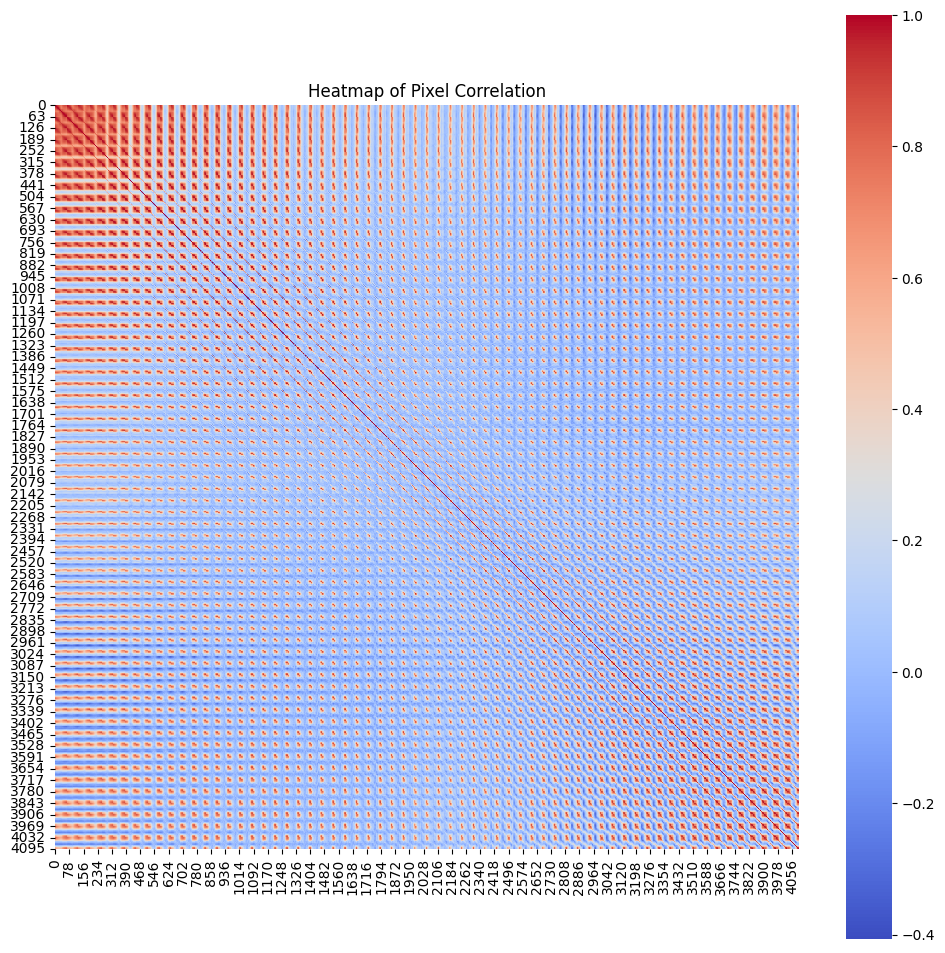

In [23]:
# Suponha que 'X_corrected_sorted' é o seu conjunto de dados de imagens corrigido e ordenado
# Vamos achatá-lo para 2D primeiro para a correlação (número de amostras, número de pixels)
X_flat = correted_X.reshape(correted_X.shape[0], -1)

# Calcular a matriz de correlação
correlation_matrix = np.corrcoef(X_flat.T)

# Gerar o mapa de calor usando seaborn
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm', square=True)
plt.title('Heatmap of Pixel Correlation')
plt.show()


### Key Observations:

- **Corner Similarities**: The corners of the heatmap show blocks of high positive correlation. This pattern suggests that pixels located in similar positions across different images—specifically the corners of the images—tend to have similar values. This similarity could be due to consistent background areas or edges that are common across the dataset.
- **Diagonal Dominance**: The heatmap exhibits a strong diagonal line of perfect positive correlation, which is expected as this represents each pixel's correlation with itself. However, the surrounding off-diagonal areas show variations in correlation, indicating diverse pixel relationships.
- **Symmetry**: The heatmap is symmetrical about the diagonal, which is characteristic of correlation matrices, as the correlation between pixel A and pixel B is the same as the correlation between pixel B and pixel A.
- **Blue to Red Gradient**: There is a visible transition from blue to red as we move from the corners toward the center along the diagonal. This gradient may represent the transition from the image background to the more varied central regions where the digit symbols are located.

### Implications for Machine Learning:

- **Feature Redundancy**: Highly correlated regions suggest redundancy in pixel information, which could be compressed or reduced without significant loss of information, thus speeding up learning algorithms and reducing the complexity of the model.
- **Background vs. Foreground**: The clear distinction between corner correlations and other areas may help in distinguishing between the background and the foreground (the digits), which is a crucial preprocessing step for segmentation and feature extraction in image recognition tasks.

Overall, this heatmap serves as a powerful exploratory tool to understand the underlying structure of the image data, guiding subsequent preprocessing and feature engineering steps. It also underlines the importance of dimensionality reduction techniques such as PCA to focus on the most informative aspects of the data for more efficient machine learning processes.

## Correlation Heatmap using PCA (Principal Component Analysis)

Principal Component Analysis (PCA) is a dimensionality reduction technique that can be used to reduce the number of features in a dataset while retaining most of the information. In the context of image data, PCA can help us visualize the correlation between pixels by reducing the dimensionality of the data to 2 or 3 dimensions.

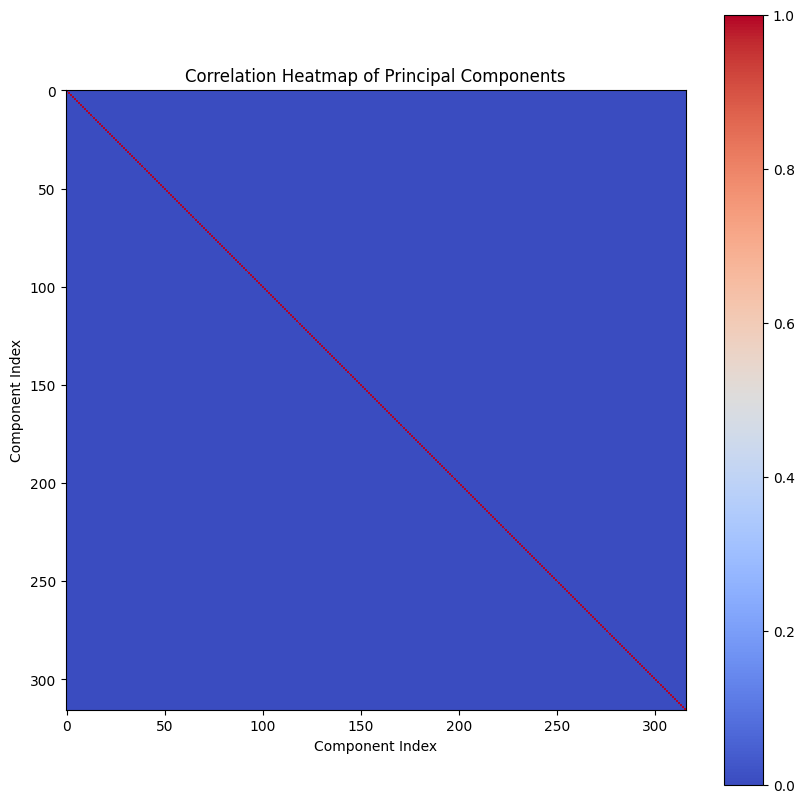

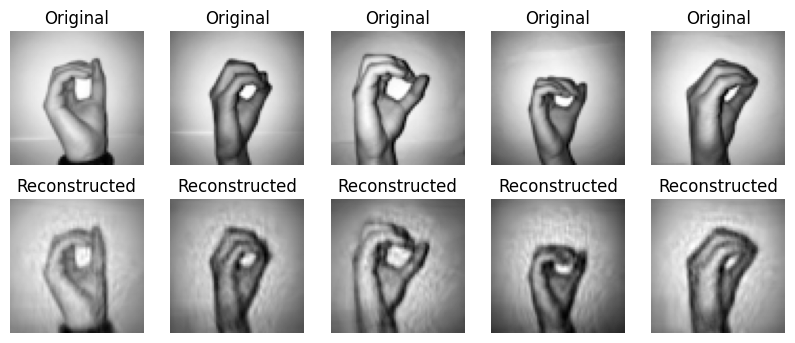

In [24]:
# Supondo que 'X_corrected_sorted' seja o conjunto de dados normalizado
# Primeiro, achatamos as imagens para a forma (n_samples, n_pixels)
X_flat = correted_X.reshape(correted_X.shape[0], -1)

# Inicializar PCA - escolhemos um número de componentes que explica uma boa porcentagem da variância
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_flat)

# Agora, podemos calcular a matriz de correlação das componentes principais
correlation_matrix_pca = np.corrcoef(X_pca.T)

# Plotar o mapa de calor usando Matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(correlation_matrix_pca, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.title('Correlation Heatmap of Principal Components')
plt.xlabel('Component Index')
plt.ylabel('Component Index')
plt.show()

X_pca_reconstructed = pca.inverse_transform(X_pca)

# Visualizar as primeiras 5 imagens reconstruídas
def plot_reconstructed_images(original, reconstructed, n=5):
    plt.figure(figsize=(10, 4))
    for i in range(n):
        # Plot original image
        plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(64, 64), cmap='gray')  # Ajuste o tamanho conforme necessário
        plt.title("Original")
        plt.axis('off')

        # Plot reconstructed image
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].reshape(64, 64), cmap='gray')  # Ajuste o tamanho conforme necessário
        plt.title("Reconstructed")
        plt.axis('off')

    plt.show()

# Usar a função para mostrar as imagens
plot_reconstructed_images(correted_X, X_pca_reconstructed, n=5)

### Correlation Heatmap:

- The heatmap displays a clear diagonal, which confirms that each principal component is orthogonal to the others, as expected from a PCA. This implies that each principal component is capturing unique variance from the dataset.

### Image Reconstruction:

- The reconstructed images, while blurrier than the originals, still retain the core structure and features. This suggests that the principal components have effectively captured the most significant variance in the data.

## Dataset Augmentation

Dataset augmentation is a common technique used to artificially increase the size of a dataset by applying various transformations to the existing data samples. This can help improve the generalization and robustness of machine learning models, especially in scenarios where the original dataset is limited in size.

Novo tamanho de X: (26806, 64, 64)
Novo tamanho de Y: (10310, 10)


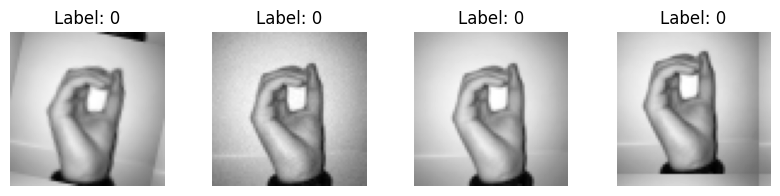

In [25]:
import numpy as np
from skimage.transform import rotate, warp, AffineTransform
from skimage.util import random_noise
from skimage.exposure import adjust_gamma
import matplotlib.pyplot as plt
import random

def rotate_images(images, num_copies=3, angle_range=(-30, 30)):
    rotated_images = []
    for image in images:
        for _ in range(num_copies):
            angle = random.uniform(*angle_range)
            rotated_images.append(rotate(image, angle, mode='wrap'))
    return rotated_images

def add_gaussian_noise(images, copies=3):
    noised_images = []
    for image in images:
        for _ in range(copies):
            noised_images.append(random_noise(image, mode='gaussian', var=0.01**2))
    return noised_images

def apply_gamma_contrast(images, copies=3):
    contrasted_images = []
    for image in images:
        for _ in range(copies):
            gamma = random.uniform(0.8, 1.2)  # Gamma values around 1 (0.8 to 1.2)
            contrasted_images.append(adjust_gamma(image, gamma))
    return contrasted_images

def translate_images(images, copies=3):
    translated_images = []
    for image in images:
        for _ in range(copies):
            translation = (random.randint(-5, 5), random.randint(-5, 5))
            transform = AffineTransform(translation=translation)
            translated_images.append(warp(image, transform, mode='wrap', preserve_range=True).astype(image.dtype))
    return translated_images

# Aplicar todas as técnicas
rotated_images = rotate_images(correted_X)
noised_images = add_gaussian_noise(correted_X)
contrasted_images = apply_gamma_contrast(correted_X)
translated_images = translate_images(correted_X)

# Concatenar todas as modificações com o dataset original
X_augmented = np.concatenate((correted_X, rotated_images, noised_images, contrasted_images, translated_images))
Y_augmented = np.concatenate((correted_Y, correted_Y, correted_Y, correted_Y, correted_Y))  # Cinco cópias: uma original + quatro modificadas

# Salvar os novos datasets em arquivos .npy
np.save('archive/Augmentation/X_augmented.npy', X_augmented)
np.save('archive/Augmentation/Y_augmented.npy', Y_augmented)

# Verificar as dimensões dos novos datasets
print(f'Novo tamanho de X: {X_augmented.shape}')
print(f'Novo tamanho de Y: {Y_augmented.shape}')

# Função para visualizar imagens e seus rótulos
def plot_images(images, labels, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap='gray')
        ax.set_title('Label: {}'.format(np.argmax(labels[i])))
        ax.axis('off')
    plt.show()

# Visualizar algumas das imagens modificadas e seus rótulos
sample_images = [rotated_images[0], noised_images[0], contrasted_images[0], translated_images[0]]
sample_labels = [correted_Y[0]] * 4
plot_images(sample_images, sample_labels, num_images=4)
